In [40]:
#librerias para exploracion de datos
import math
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import tensorflow as tf
from scipy import stats

#libreias para ploteo
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf


pd.options.display.float_format='{:,.2f}'.format #damos formato de dos decimales para mejor visualizacion de los datos
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore')

In [2]:
#exploracion de datos
test = pd.read_excel(r'D:\Proyectos\Datathon\bike_test.xlsx')
train = pd.read_excel(r'D:\Proyectos\Datathon\bike_train.xlsx')

________________

# Análisis de datos de entrenamiento

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11999 entries, 0 to 11998
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     11999 non-null  int64         
 1   dteday      11999 non-null  datetime64[ns]
 2   season      11999 non-null  int64         
 3   yr          11999 non-null  int64         
 4   mnth        11999 non-null  int64         
 5   hr          11999 non-null  int64         
 6   holiday     11999 non-null  int64         
 7   weekday     11999 non-null  int64         
 8   workingday  11999 non-null  int64         
 9   weathersit  11999 non-null  int64         
 10  temp        11999 non-null  float64       
 11  atemp       11999 non-null  float64       
 12  hum         11999 non-null  float64       
 13  windspeed   11999 non-null  float64       
 14  casual      11999 non-null  int64         
 15  registered  11999 non-null  int64         
 16  cnt         11999 non-

In [4]:
#Funicon para la obtendion de los indicadores de quantiles
def quan(df, nomId, nomQua): #se le pasa dataframe, nombre (ID) y el campo a analizar
    lista_id = []
    lista_minimo= []
    lista_maximo= []
    uni = df[nomId].unique()  
    i_max = len(df[nomId].unique())
    i = 0 
     
    for id in uni:
        i+=1    
        q1 = df[df[nomId] == id][nomQua].quantile(0.25) # Cuantil < 25%
        mediana = df[df[nomId] == id][nomQua].quantile(0.5) #Media
        q3 = df[df[nomId] == id][nomQua].quantile(0.75) # cuantil > 75%
        
        iqr = q3 - q1 #rango intercuartil
        minimo = mediana - 1.5 * iqr # < 15%
        maximo = mediana + 1.5 * iqr # > 75%  
        if (minimo< 0.001):
            minimo= 0.001
            
        lista_id.append(id)
        lista_minimo.append(minimo)
        lista_maximo.append(maximo)
        
        lst = list(zip(lista_id, lista_minimo, lista_maximo))
        dfin = pd.DataFrame(lst , columns = [nomId,'minimo','maximo'])      
        #clear_output(wait=True)
        #print('Completado: ' + str(round(i / i_max * 100, 2)) + '%')
    
    return dfin

def evaluacion_calidad_outliers(dato, desde, hasta):
    calidad = 'Sin errores'
    if (str(dato) == 'nan'):
        calidad = 'Valor Nulo'
        return calidad
    if ((dato < desde) or (dato > hasta)):
        calidad = 'Outlier'
        return calidad
    return calidad

def ploteo_Calidad(df, columna):
    """
    Esta función recibe de parámetros un objeto dataframe y el nombre de la columna por la cuál se va a realizar el gráfico
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    test_per = df.groupby(columna).agg(Porcentage =(columna, lambda p: p.count() / df[columna].count() * 100)).round(2)
    sns.set_style("whitegrid")
    bar,ax = plt.subplots(figsize=(10,6))
    ax = sns.barplot(x=test_per.index, y='Porcentage', data=test_per, ci=None, palette="pastel",orient='v', )
    ax.set_title(columna, fontsize=15)
    ax.set_xlabel ("Estado")
    ax.set_ylabel ("Porcentage")
    # calculate the percentages and annotate the sns barplot
    for rect in ax.patches:
        ax.text (rect.get_x() + rect.get_width() / 2,rect.get_height(),"%.1f%%"% rect.get_height(), weight='bold' )
    #bar.savefig(ubicacion + '\\' + columna + ".png");
    plt.show()

In [5]:
#Funcion que recibe como parametro una DF para evaluacion de la calidad de los datos de este
def calidaDato (data):
    df = data
    calidad = []
    mascara = df.isna().sum() #mascara con la suma d los datos nulos
    for i in range(0,len(mascara)):
        p = (df.shape[0]- mascara[i]) / df.shape[0] #colum[(total - nulo)/total]
        calidad.append([mascara.index[i], round((p*100),2)]) #Agregando el % d ecalidad
   
    calidad = pd.DataFrame(calidad)
    calidad.rename(columns={0:'Columna', 1: 'Calida %'}, inplace=True)
    
    return calidad

       Columna  Calida %
0      instant    100.00
1       dteday    100.00
2       season    100.00
3           yr    100.00
4         mnth    100.00
5           hr    100.00
6      holiday    100.00
7      weekday    100.00
8   workingday    100.00
9   weathersit    100.00
10        temp    100.00
11       atemp    100.00
12         hum    100.00
13   windspeed    100.00
14      casual    100.00
15  registered    100.00
16         cnt    100.00


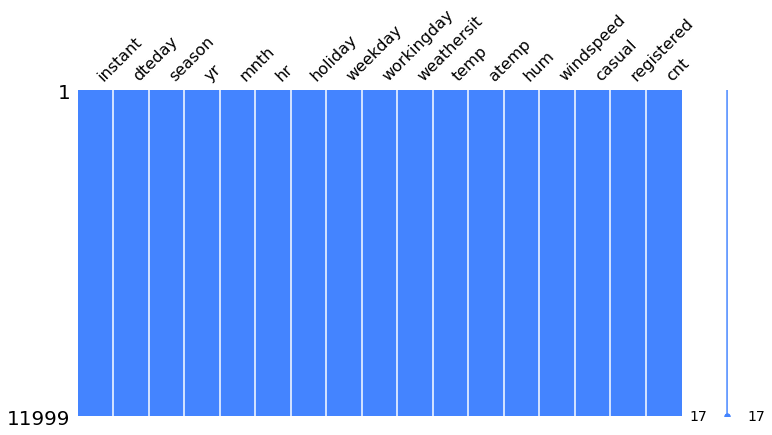

In [6]:
#calidad de los datos de la data para el entrenamiento
msno.matrix(train, figsize=(12,6),color=(0.27, 0.52, 1.0)) #colores de ploteo( 0.3,0.36,0.44 / 1, 0.38, 0.27 / 0.27, 0.52, 1.0)
print(calidaDato(train))

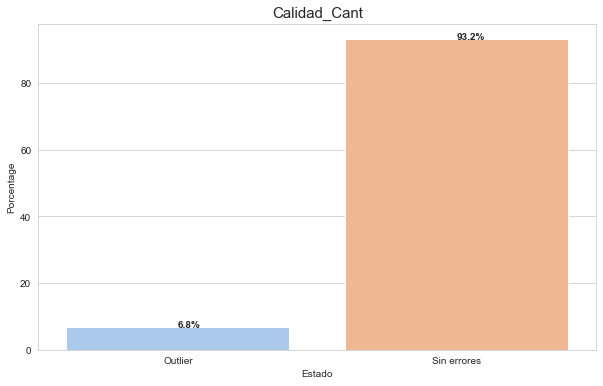

In [7]:
df = quan(train,'dteday', 'cnt')
train = pd.merge(train, df[['dteday', 'minimo', 'maximo']], on=['dteday'], how='left')
train['Calidad_Cant'] = train.apply(lambda row: evaluacion_calidad_outliers(row['cnt'], row['minimo'], row['maximo']), axis=1)
ploteo_Calidad(train, 'Calidad_Cant')

se puede apreciar que se cuenta con outliers menor al 10% de los datos


________________

# normalizacón

In [8]:
# eliminamos outliers
train_sinOut = train.drop(train[train['Calidad_Cant']=='Outlier'].index)

In [9]:
train.shape, train_sinOut.shape

((11999, 20), (11181, 20))

In [379]:
df_test = test.copy()
df_train = train_sinOut.copy()

In [380]:
#normlizacion de fecha, incluimos la hora
df_train["dteday"]= pd.to_datetime(df_train["dteday"])
df_train["dteday"]=pd.to_datetime(df_train["dteday"]) + pd.to_timedelta(df_train['hr'], unit='h')
df_train.head(5)

df_test["dteday"]= pd.to_datetime(df_test["dteday"])
df_test["dteday"]=pd.to_datetime(df_test["dteday"]) + pd.to_timedelta(df_test['hr'], unit='h')
df_test.head(5)

#Eliminamos la columanas que no se contemplan en test
df_train.drop(columns={'instant', 'casual', 'registered', 'minimo',	'maximo', 'Calidad_Cant'}, inplace=True)
df_test.drop(columns='instant', inplace=True)
#Seteamos los indices, ya qwue trabajaremos la fecha como indice, ya que no podemos tomar como serie de tiempo
df_train.set_index('dteday', inplace=True)
df_test.set_index('dteday', inplace=True)

# Graficos para evaluación de los datos

In [131]:
df_train = df_train.asfreq('H')
df_train = df_train.sort_index()

In [132]:
fin_train = '2012-03-30 23:59:00'
fin_validacion = '2012-05-20 23:59:00'
datos_train = df_train.loc[: fin_train, :]
datos_val   = df_train.loc[fin_train:fin_validacion, :]
datos_test = df_test

In [95]:
print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 0 --- 2011  (n=1854)
Fechas validacion : nan --- nan  (n=0)
Fechas test       : 0 --- 5379  (n=5380)


In [96]:
datos_test['cnt'] = 0

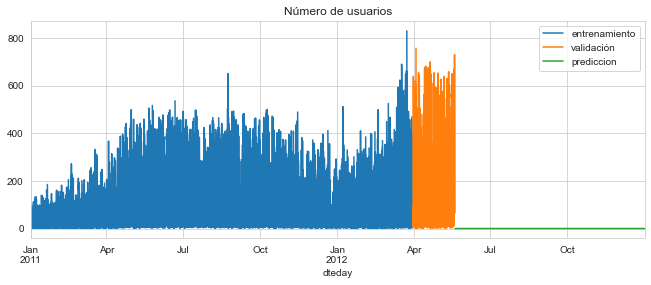

In [27]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['cnt'].plot(ax=ax, label='entrenamiento')
datos_val['cnt'].plot(ax=ax, label='validación')
datos_test['cnt'].plot(ax=ax, label='prediccion')
ax.set_title('Número de usuarios')
ax.legend()

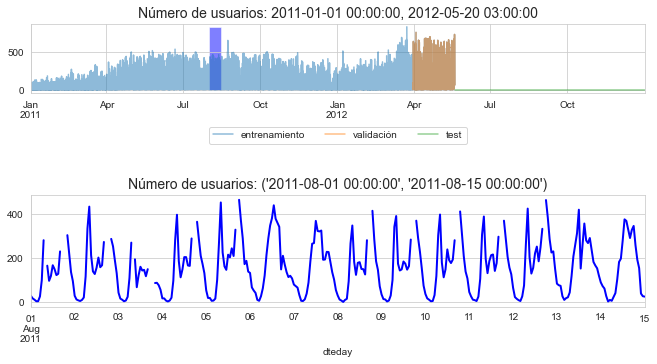

In [30]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2011-08-01 00:00:00','2011-08-15 00:00:00')

fig = plt.figure(figsize=(11, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

df_train['cnt'].plot(ax=main_ax, label='entrenamiento', alpha=0.5)
datos_val['cnt'].plot(ax=main_ax, label='validación', alpha=0.5)
datos_test['cnt'].plot(ax=main_ax, label='test', alpha=0.5)
min_y = min(df_train['cnt'])
max_y = max(df_train['cnt'])
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
main_ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))

df_train.loc[zoom[0]: zoom[1]]['cnt'].plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Número de usuarios: {df_train.index.min()}, {df_train.index.max()}', fontsize=14)
zoom_ax.set_title(f'Número de usuarios: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

In [35]:
df_train_fin = df_train.copy()

In [37]:
# Gráfico interactivo serie temporal
# ==============================================================================
df_train_fin.loc[:fin_train, 'particion'] = 'entrenamiento'
df_train_fin.loc[fin_train:fin_validacion, 'particion'] = 'validación'
df_train_fin.loc[fin_validacion:, 'particion'] = 'test'

fig = px.line(
    data_frame = df_train_fin.reset_index(),
    x      = 'dteday',
    y      = 'cnt',
    color  = 'particion',
    title  = 'Número de usuarios',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

df_train_fin=df_train_fin.drop(columns='particion')

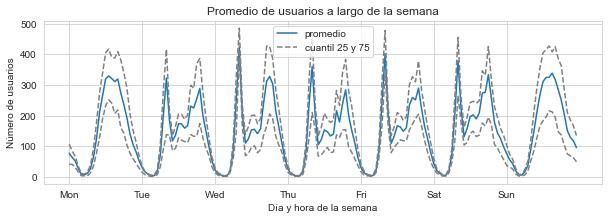

In [38]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
promedio_dia_hora = df_train_fin.groupby(["weekday", "hr"])["cnt"].mean()
q25_dia_hora = df_train_fin.groupby(["weekday", "hr"])["cnt"].quantile(0.25)
q75_dia_hora = df_train_fin.groupby(["weekday", "hr"])["cnt"].quantile(0.75)

promedio_dia_hora.plot(ax=ax, label='promedio')
q25_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='')
q75_dia_hora.plot(ax=ax, linestyle='dashed', color='gray', label='cuantil 25 y 75')


ax.set(
    title="Promedio de usuarios a largo de la semana",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    xlabel="Día y hora de la semana",
    ylabel="Número de usuarios"
)

ax.legend()

In [223]:
colum = ['season', 'weekday', 'workingday', 'weathersit', 'holiday']

---------------------------
season


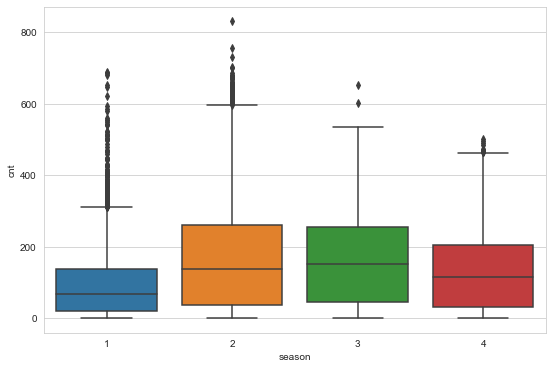

season
1    353099
2    581763
3    349196
4    269282
Name: cnt, dtype: int64 season
1    3680
2    3404
3    2097
4    2000
Name: cnt, dtype: int64
---------------------------
weekday


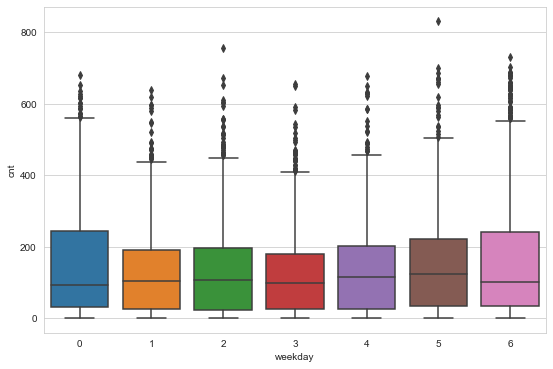

weekday
0    254301
1    199511
2    201678
3    185611
4    205324
5    234024
6    272891
Name: cnt, dtype: int64 weekday
0    1690
1    1565
2    1531
3    1531
4    1544
5    1599
6    1721
Name: cnt, dtype: int64
---------------------------
workingday


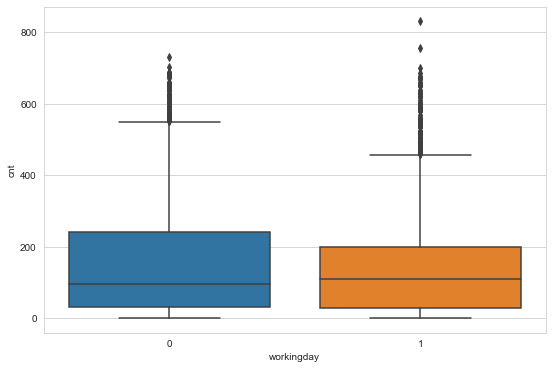

workingday
0    569231
1    984109
Name: cnt, dtype: int64 workingday
0    3740
1    7441
Name: cnt, dtype: int64
---------------------------
weathersit


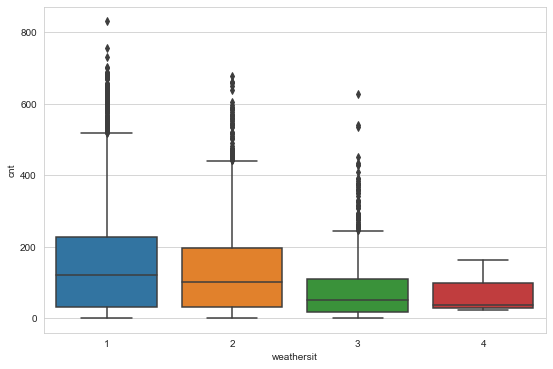

weathersit
1    1093779
2     381311
3      78027
4        223
Name: cnt, dtype: int64 weathersit
1    7282
2    2897
3     999
4       3
Name: cnt, dtype: int64


In [199]:
for i in colum:
    print('---------------------------')
    print(i)
    fig, ax =plt.subplots(figsize=(9,6))
    sns.boxplot(data=df_train, y='cnt', x=i)
    plt.show()
    tot = df_train.groupby(i)['cnt'].sum()
    cont = df_train.groupby(i)['cnt'].count()
    print(tot, cont)
    

In [44]:
df_train_analisis = df_train.copy()
df_train_analisis.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,"11,181.00","11,181.00","11,181.00","11,181.00","11,181.00","11,181.00","11,181.00","11,181.00","11,181.00","11,181.00","11,181.00","11,181.00","11,181.00"
mean,2.22,0.28,5.56,11.33,0.03,3.02,0.67,1.44,0.46,0.45,0.63,0.19,138.93
std,1.09,0.45,3.43,7.01,0.17,2.04,0.47,0.65,0.19,0.17,0.20,0.12,129.26
min,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.02,0.00,0.00,0.00,1.00
25%,1.00,0.00,3.00,5.00,0.00,1.00,0.00,1.00,0.32,0.30,0.47,0.10,30.00
50%,2.00,0.00,5.00,11.00,0.00,3.00,1.00,1.00,0.46,0.45,0.63,0.19,106.00
75%,3.00,1.00,8.00,17.00,0.00,5.00,1.00,2.00,0.62,0.59,0.80,0.28,208.00
max,4.00,1.00,12.00,23.00,1.00,6.00,1.00,4.00,0.96,1.00,1.00,0.85,830.00


In [45]:
#calculando la matriz de correlacion de todo los datos
corr = df_train_analisis.corr(method='pearson')

<AxesSubplot:>

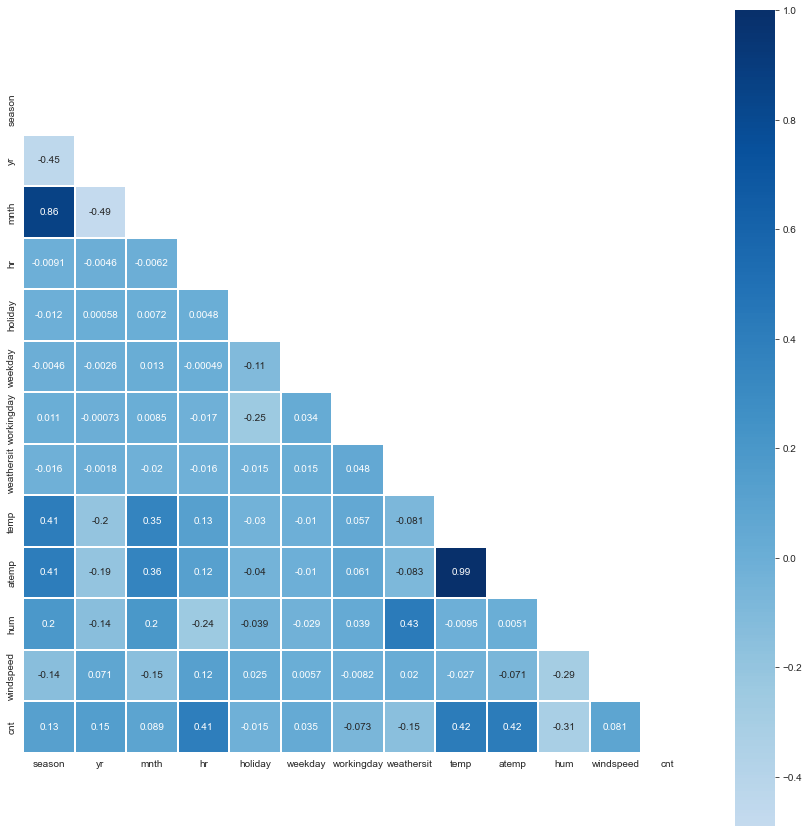

In [46]:
#generando mascara para el triangulo superior 
mask = np.triu(np.ones_like(corr, dtype=bool))
#figura para ploteo
f , ax = plt.subplots(figsize=(15,15))
#dibuja el mapa de calor con la máscara y la relación de aspecto correcto
sns.heatmap(corr, mask=mask, cmap='Blues',  vmax=1, center=0,
            square=True, linewidths=.1, annot=True)

* Se eliminara los que tiene correlacion altas 
* Correlación casi nula con cnt, se considera un rango entre -0.1 a 0.1

In [47]:
list_plot = ['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']

In [182]:
#Probar si una serie de tiempo dada es estacionaria o no
from statsmodels.tsa.stattools import adfuller
for i in list_plot:
    x = df_train[i].values
    x = np.nan_to_num(x)
    result = adfuller(x)
    print(i), print('ADF static: %f' % result[0]), print('p-value: %f' % result[1]), print('Critical values')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

hr
ADF static: -16.402379
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
weathersit
ADF static: -21.264111
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
temp
ADF static: -3.947775
p-value: 0.001710
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
hum
ADF static: -10.209541
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
windspeed
ADF static: -13.387015
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567
cnt
ADF static: -6.896112
p-value: 0.000000
Critical values
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [128]:
list_plot = ['hr', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']

hr


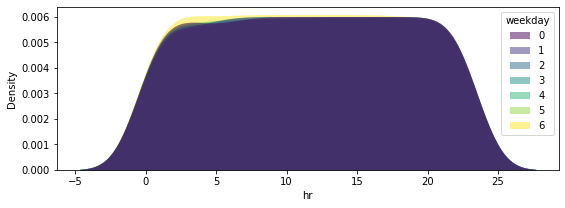

weathersit


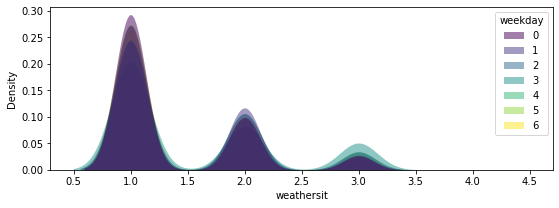

temp


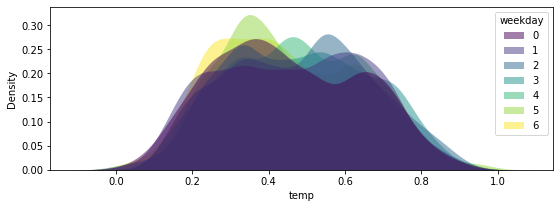

hum


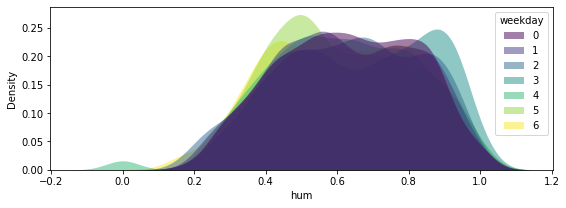

windspeed


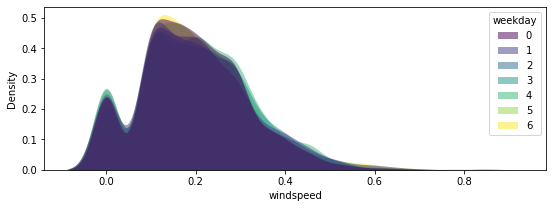

cnt


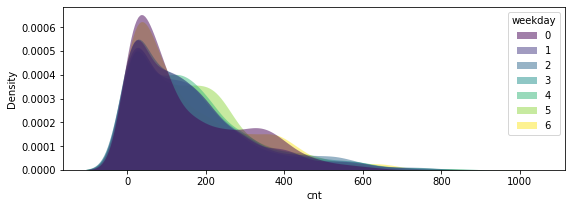

In [129]:
#ploteamos los datos por su calidad
for i in list_plot:
    print(i)
    fig, ax =plt.subplots(figsize=(9,3))
    sns.kdeplot(data=df_train, x=i, hue='weekday', fill=True, alpha=.5, linewidth=0, palette='viridis')
    plt.show()

______________________
season


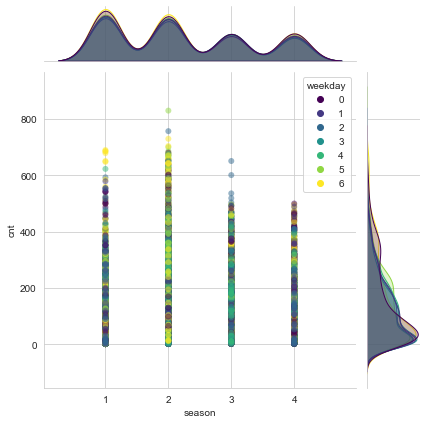

______________________
yr


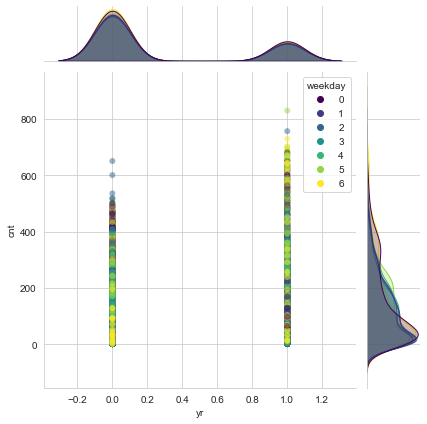

______________________
hr


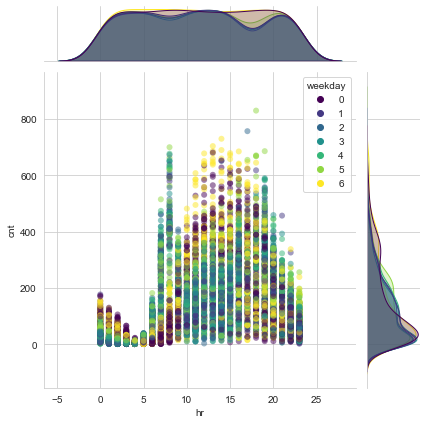

______________________
holiday


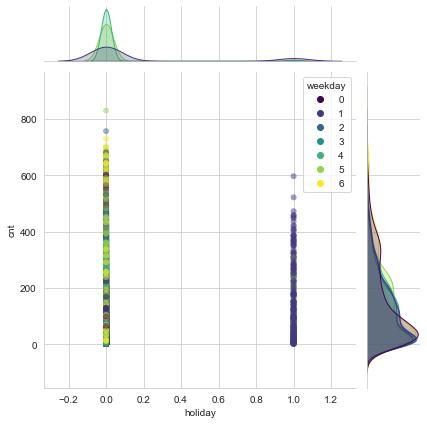

______________________
weekday


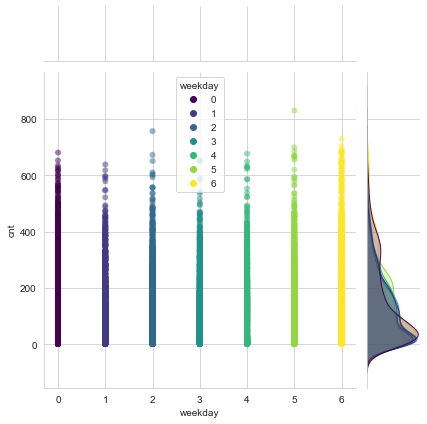

______________________
workingday


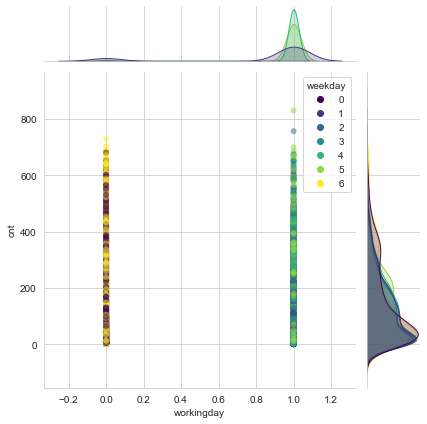

______________________
weathersit


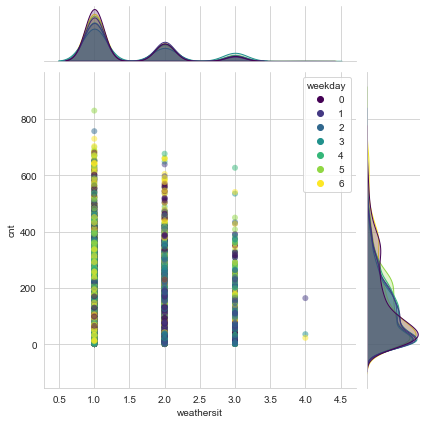

______________________
temp


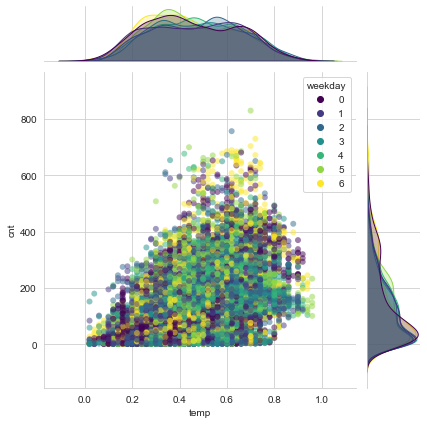

______________________
hum


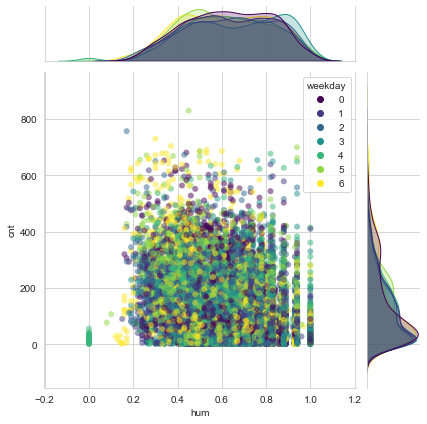

______________________
windspeed


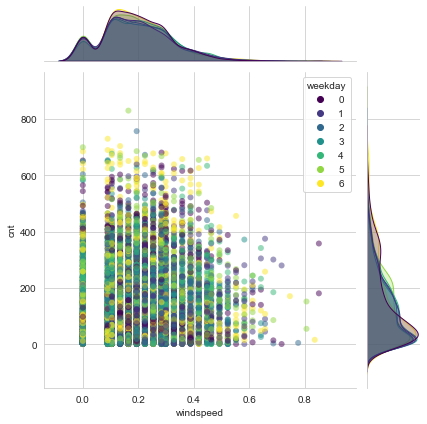

______________________
cnt


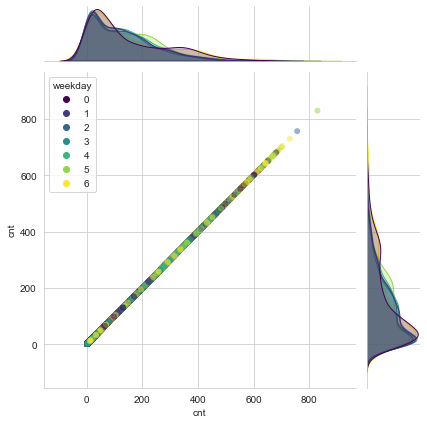

In [48]:
#ploteamos los datos por su calidad y dispersion
for i in list_plot:
    print('______________________')
    print(i)
    sns.jointplot(data=df_train, y='cnt', x=i, hue='weekday', alpha=.5, linewidth=0, palette='viridis')
    plt.show()

comparamos los dos series de tiempos (data original y de diferenciación)

________
# Visualización de variable categóricos

In [170]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11181 entries, 2011-01-01 00:00:00 to 2012-05-20 03:00:00
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      11181 non-null  int64  
 1   yr          11181 non-null  int64  
 2   mnth        11181 non-null  int64  
 3   hr          11181 non-null  int64  
 4   holiday     11181 non-null  int64  
 5   weekday     11181 non-null  int64  
 6   workingday  11181 non-null  int64  
 7   weathersit  11181 non-null  int64  
 8   temp        11181 non-null  float64
 9   atemp       11181 non-null  float64
 10  hum         11181 non-null  float64
 11  windspeed   11181 non-null  float64
 12  cnt         11181 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.2 MB


In [322]:
# identificaoms las variables categoricas
var_cate= ["season", "hr", "holiday", "weekday", "workingday"]
for i in var_cate:
    df_train[i] = df_train[i].astype('category')


                        Visualización de variables categóricos (train):                         


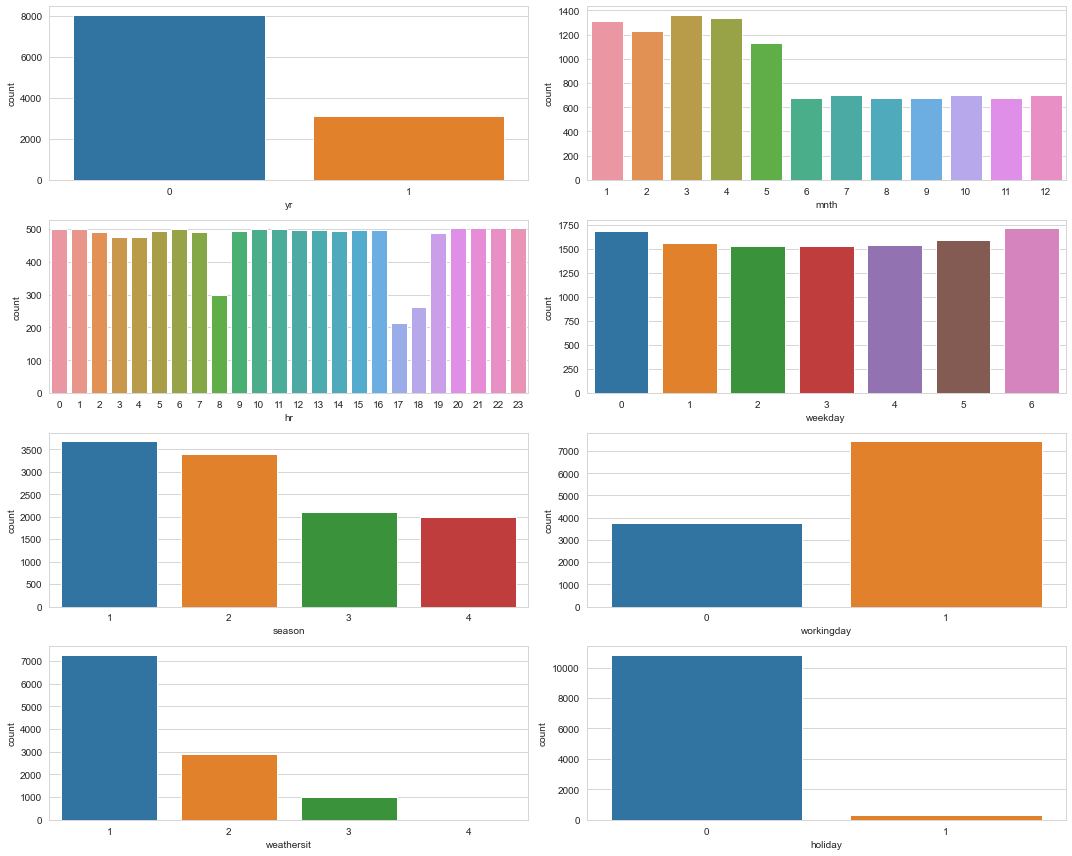

In [173]:
print('\033[2mVisualización de variables categóricos (train):'.center(100))
cf = ["yr","mnth","hr","weekday","season", "workingday","weathersit","holiday"]
n = 2
plt.figure(figsize = [15,3* math.ceil(len(cf)/n)])

for i in range(len(cf)):
    if df_train[cf[i]].nunique() <= 6: # Cantidad de valores unicos de la serie 
        plt.subplot(math.ceil(len(cf)/n), n, i+1)
        sns.countplot(df_train[cf[i]])
    else:
        plt.subplot(4, 2, i+1)
        sns.countplot(df_train[cf[i]])

plt.tight_layout()
plt.show()

                                           Distribución de datos numéricos (train)                                            


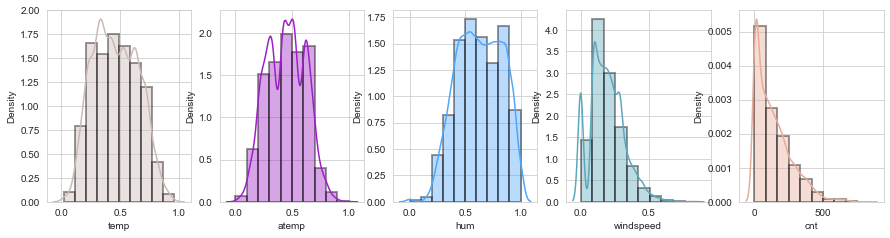

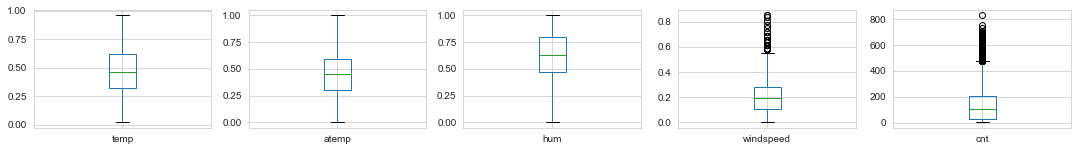

In [175]:
print('\033[1mDistribución de datos numéricos (train)'.center(130))

n = 5
nf = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
clr = ['r', 'g', 'b', 'g', 'b', 'r']

plt.figure(figsize = [15, 6*math.ceil(len(cf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    sns.distplot(df_train[nf[i]], hist_kws = dict(edgecolor = 'black', linewidth = 2), 
               bins = 10, color = list(np.random.randint([255,255,255])/255))
    
plt.figure(figsize = [15, 6*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/2), n, i+1)
    df_train.boxplot(nf[i])

plt.tight_layout()
plt.show()

In [176]:
df_train.reset_index(drop=False, inplace=True)

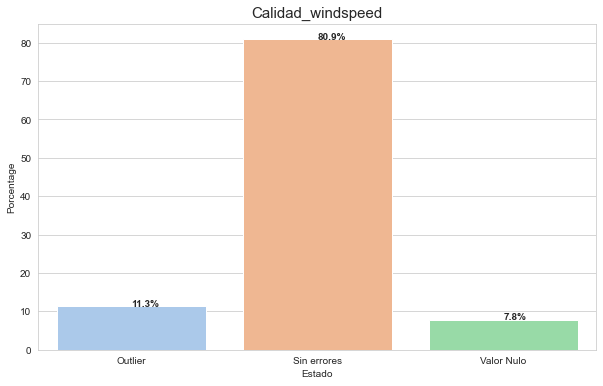

In [139]:
df = quan(df_train,'dteday', 'windspeed')
df_train = pd.merge(df_train, df[['dteday', 'minimo', 'maximo']], on=['dteday'], how='left')
df_train['Calidad_windspeed'] = df_train.apply(lambda row: evaluacion_calidad_outliers(row['windspeed'], row['minimo'], row['maximo']), axis=1)
ploteo_Calidad(df_train, 'Calidad_windspeed')

In [327]:
df_train.set_index('dteday', inplace=True)
df_train.drop(columns='windspeed', inplace=True)

Distribución de datos de cantidad de alquiler por día (train)


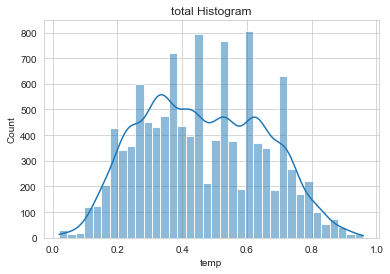

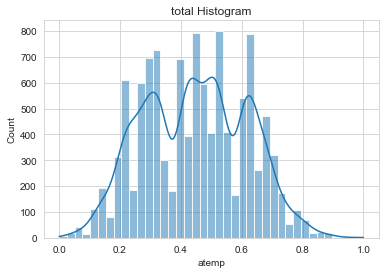

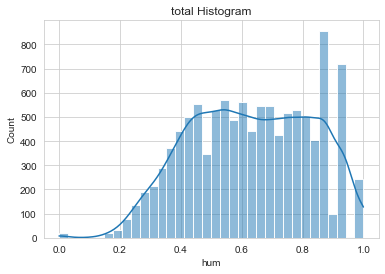

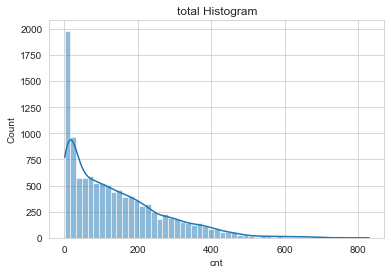

In [178]:
print('\033[1mDistribución de datos de cantidad de alquiler por día (train)'.center(50))
# train_target histogram 
nf = ['temp', 'atemp', 'hum', 'cnt']
for i in nf:
    plt.title('total Histogram')
    sns.histplot(df_train[i], kde=True)
    plt.show()

In [262]:
#aplicamor el logaritmo a las variables numericos
for i in nf:
    df_train[i] = np.log1p(df_train[i])

In [323]:
#aplicamor el logaritmo a cnt
df_train['cnt'] = np.log1p(df_train['cnt'])

Distribución de datos de cantidad de alquiler por día (train)


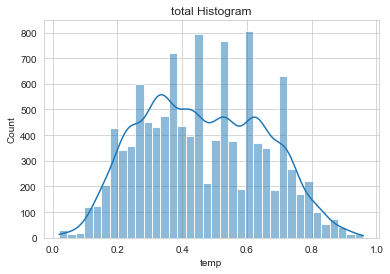

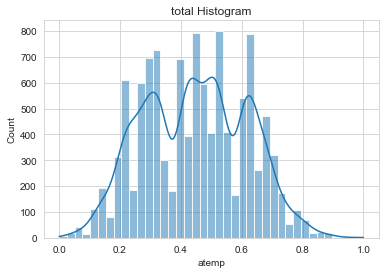

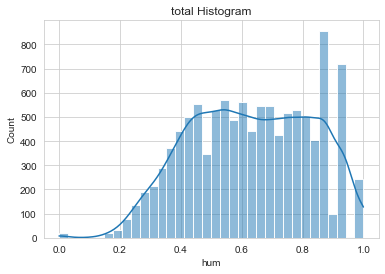

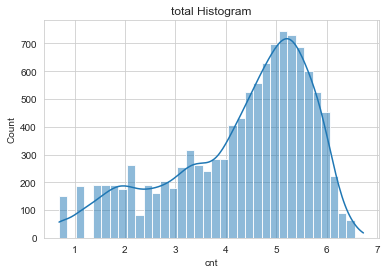

In [324]:
print('\033[1mDistribución de datos de cantidad de alquiler por día (train)'.center(50))
# train_target histogram 
for i in nf:
    plt.title('total Histogram')
    sns.histplot(df_train[i], kde=True)
    plt.show()

_______
# tratamiento de test

In [325]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5380 entries, 2012-05-20 04:00:00 to 2012-12-31 23:00:00
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      5380 non-null   int64  
 1   yr          5380 non-null   int64  
 2   mnth        5380 non-null   int64  
 3   hr          5380 non-null   int64  
 4   holiday     5380 non-null   int64  
 5   weekday     5380 non-null   int64  
 6   workingday  5380 non-null   int64  
 7   weathersit  5380 non-null   int64  
 8   temp        5380 non-null   float64
 9   atemp       5380 non-null   float64
 10  hum         5380 non-null   float64
 11  windspeed   5380 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 546.4 KB


In [ ]:
df_train.drop(columns=['minimo', 'maximo', 'Calidad_windspeed'], inplace=True)

In [331]:
# identificaoms las variables categoricas
var_cate= ['season',"hr", "holiday", "weekday", "workingday"]
for i in var_cate:
    df_test[i] = df_test[i].astype('category')

In [264]:
#aplicamor el logaritmo a las variables numericos
var_num = ['temp', 'atemp', 'hum']
for i in var_num:
    df_test[i] = np.log1p(df_test[i])

In [328]:
df_test.drop(columns='windspeed', inplace=True)

In [ ]:
from statsmodels.graphics.gofplots import qqplot
for i in list_plot:
    print (i)
    y = df_train[i].fillna(0)
    #x = df[i].fillna(0)
    plt.rc('figure', figsize=(5,5), )
    qqplot(y, line='q')
    #qqplot(x, line='q')
    plt.show()

_____________

# extraemos datos para entrenamiento

In [334]:
train_target = df_train['cnt']
train_feature = df_train.drop(['cnt'], axis=1)
train_target.shape, train_feature.shape

((11181,), (11181, 11))

In [276]:
train_target.describe()

count   11,181.00
mean         4.30
std          1.38
min          0.69
25%          3.43
50%          4.67
75%          5.34
max          6.72
Name: cnt, dtype: float64

# Modelando los datos para entrenamiento

In [335]:
train_feature.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11181 entries, 2011-01-01 00:00:00 to 2012-05-20 03:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      11181 non-null  category
 1   yr          11181 non-null  int64   
 2   mnth        11181 non-null  int64   
 3   hr          11181 non-null  category
 4   holiday     11181 non-null  category
 5   weekday     11181 non-null  category
 6   workingday  11181 non-null  category
 7   weathersit  11181 non-null  int64   
 8   temp        11181 non-null  float64 
 9   atemp       11181 non-null  float64 
 10  hum         11181 non-null  float64 
dtypes: category(5), float64(3), int64(3)
memory usage: 667.6 KB


In [336]:
#acomodamos las variables categoricos
train_featute_fin = pd.get_dummies(train_feature, columns=['season', 'hr', 'holiday', 'weekday','workingday'])
train_featute_fin.columns

Index(['yr', 'mnth', 'weathersit', 'temp', 'atemp', 'hum', 'season_1',
       'season_2', 'season_3', 'season_4', 'hr_0', 'hr_1', 'hr_2', 'hr_3',
       'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11',
       'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_20', 'hr_21', 'hr_22', 'hr_23', 'holiday_0', 'holiday_1',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'workingday_0', 'workingday_1'],
      dtype='object')

In [337]:
#acomodamos las variables categoricos
test_fin = pd.get_dummies(df_test, columns=['season', 'hr', 'holiday', 'weekday','workingday'])
test_fin.columns

Index(['yr', 'mnth', 'weathersit', 'temp', 'atemp', 'hum', 'season_1',
       'season_2', 'season_3', 'season_4', 'hr_0', 'hr_1', 'hr_2', 'hr_3',
       'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11',
       'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_20', 'hr_21', 'hr_22', 'hr_23', 'holiday_0', 'holiday_1',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'workingday_0', 'workingday_1'],
      dtype='object')

In [338]:
train_featute_fin.columns == test_fin.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

_______

dividimos la matrices en subconjuntos (aleatorios) para datos de trenes y pruebas

In [222]:
from sklearn.model_selection import train_test_split 

X_train, X_validation, y_train, y_validation = train_test_split(train_featute_fin, train_target, test_size=0.20, random_state=4200)
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((8944, 45), (2237, 45), (8944,), (2237,))

In [198]:
# función para hallar el error de registro de raíz cuadrática media
def rmsle(y, pred):  
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    print('RMSLE: {0:.3f}'.format(rmsle_val))

In [199]:
#funcion para entrenamiento de modelos
def get_model_predict(model, X_train, X_validation, y_train, y_validation, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_validation)

    print('#',model.__class__.__name__,)
    evaluate_regr(y_validation, pred) 

aplicacion de modelos de linea de regresión

In [223]:
from sklearn.linear_model import LinearRegression , Ridge , Lasso

In [224]:
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.001)

In [225]:
for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_validation, y_train, y_validation,is_expm1=True)

# LinearRegression
RMSLE: 0.148
# Ridge
RMSLE: 0.148
# Lasso
RMSLE: 0.148


Aplicar modelos RF, GBM, XGBoost, LightGBM

In [233]:
var_cate= ['yr','mnth', 'weathersit']
for i in var_cate:
    train_featute_fin[i] = train_featute_fin[i].astype('float')
    test_fin[i] = test_fin[i].astype('float')

In [354]:
from sklearn.model_selection import train_test_split 

X_train, X_validation, y_train, y_validation = train_test_split(train_featute_fin, train_target, test_size=0.15, random_state=4200)
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((9503, 45), (1678, 45), (9503,), (1678,))

In [355]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=600)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

In [356]:
for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,X_train, X_validation, y_train, y_validation)

# RandomForestRegressor
RMSLE: 0.095
# GradientBoostingRegressor
RMSLE: 0.091
# XGBRegressor
RMSLE: 0.093
# LGBMRegressor
RMSLE: 0.085


In [357]:
from sklearn.model_selection import cross_val_score
mod = [RandomForestRegressor, GradientBoostingRegressor, XGBRegressor, LGBMRegressor]
for i in mod:
    rf = i()
    print('# cross val ',rf.__class__.__name__,)
    print(np.mean(cross_val_score(rf, X_train, y_train, cv=5)))

# cross val  RandomForestRegressor
0.9274390017997206
# cross val  GradientBoostingRegressor
0.8638533704172232
# cross val  XGBRegressor
0.9363201078627268
# cross val  LGBMRegressor
0.9371832071618901


In [260]:
#Funcion para subir archivo a una carpeta
from pathlib import Path
def subircsv(nomcarpeta, nomarchivo, extencion, df):
    filepath = Path(nomcarpeta + '/' + nomarchivo +'.' + extencion)  
    filepath.parent.mkdir(parents=True, exist_ok=True)  
    df.to_csv(filepath, index = False)

Predicción con RandomForestRegressor

In [358]:
prediccion = rf_reg.predict(test_fin)
prediccion[0:10]

array([2.43857954, 2.33082332, 3.02411102, 4.30986035, 5.09722172,
       5.7266646 , 6.16521489, 6.31880998, 6.38082819, 6.3981952 ])

In [359]:
#Volver a los valores originales cantidad
prediccion_cnt = np.expm1(prediccion)
prediccion_cnt[0:10]

array([ 10.45675534,   9.286407  ,  19.57570517,  73.43009405,
       162.56684034, 305.94377864, 474.90340075, 553.9122448 ,
       589.41648387, 599.75980808])

In [360]:
prediccion_cnt = np.round(prediccion_cnt, 0)
prediccion_cnt

array([ 10.,   9.,  20., ..., 133., 103.,  53.])

In [370]:
df = pd.DataFrame(prediccion_cnt)
df.rename(columns={0:'cnt'}, inplace=True)


In [372]:
df_test.reset_index(drop=False, inplace=True)

In [373]:
predic = pd.concat([df_test, df], axis=1)

In [374]:
predic.set_index('dteday', inplace=True)

In [375]:
df_train['cnt'] = np.expm1(df_train['cnt'])

In [381]:
fin_train = '2012-03-30 23:59:00'
fin_validacion = '2012-05-20 23:59:00'
datos_train = df_train.loc[: fin_train, :]
datos_val   = df_train.loc[fin_train:fin_validacion, :]
datos_test = predic

In [352]:
print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2011-01-01 00:00:00 --- 2012-03-30 23:00:00  (n=10054)
Fechas validacion : 2012-03-31 00:00:00 --- 2012-05-20 03:00:00  (n=1127)
Fechas test       : 2012-05-20 04:00:00 --- 2012-12-31 23:00:00  (n=5380)


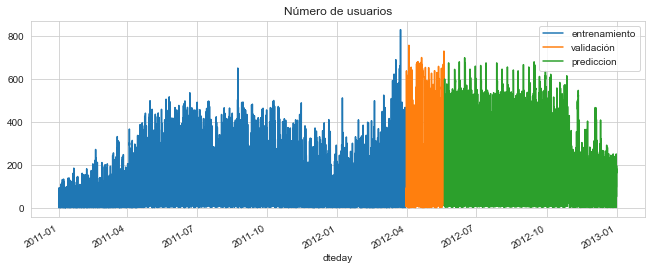

In [382]:
fig, ax = plt.subplots(figsize=(11, 4))
datos_train['cnt'].plot(ax=ax, label='entrenamiento')
datos_val['cnt'].plot(ax=ax, label='validación')
datos_test['cnt'].plot(ax=ax, label='prediccion')
ax.set_title('Número de usuarios')
ax.legend()